### Bayesian Change Point model implementation

In [7]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

%matplotlib inline


In [8]:
%pip install pandas
%pip install pymc
%pip install arviz
%pip install matplotlib

import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_28200\210397671.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28200\210397671.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index('Date').resample('1M').mean().dropna().reset_index()


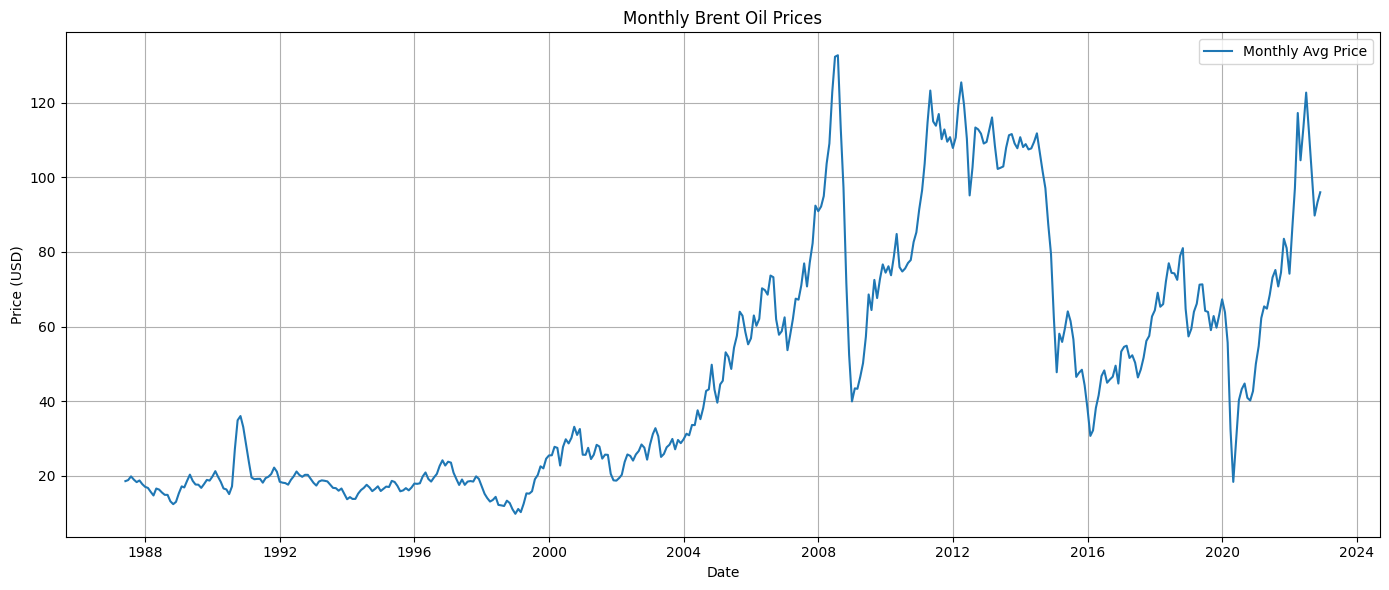

In [18]:
# Cell 2: Load and preprocess data
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Monthly average for fewer samples
df_monthly = df.set_index('Date').resample('1M').mean().dropna().reset_index()

time = np.arange(len(df_monthly))
price = df_monthly['Price'].values

plt.figure(figsize=(14, 6))
plt.plot(df_monthly['Date'], price, label='Monthly Avg Price')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Monthly Brent Oil Prices")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
#df = pd.read_csv("BrentOilPrices.csv")
df = pd.read_csv("../data/BrentOilPrices.csv")  # Example if it's in a parent 'data' folder

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Monthly aggregation to reduce noise and sample size
df_monthly = df.set_index('Date').resample('1M').mean().dropna().reset_index()

# Define time and price for modeling
time = np.arange(len(df_monthly))
price = df_monthly['Price'].values


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2456\302672247.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2456\302672247.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index('Date').resample('1M').mean().dropna().reset_index()


In [6]:
import pymc as pm

with pm.Model() as model:
    # Priors
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(price) - 1)
    mu1 = pm.Normal('mu1', mu=np.mean(price), sigma=10)
    mu2 = pm.Normal('mu2', mu=np.mean(price), sigma=10)
    sigma1 = pm.HalfNormal('sigma1', sigma=10)
    sigma2 = pm.HalfNormal('sigma2', sigma=10)

    # Change point logic using switch
    mu = pm.math.switch(time < tau, mu1, mu2)
    sigma = pm.math.switch(time < tau, sigma1, sigma2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=price)

    # Inference
    trace = pm.sample(1000, tune=500, target_accept=0.95, cores=1, return_inferencedata=True)


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 1395 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


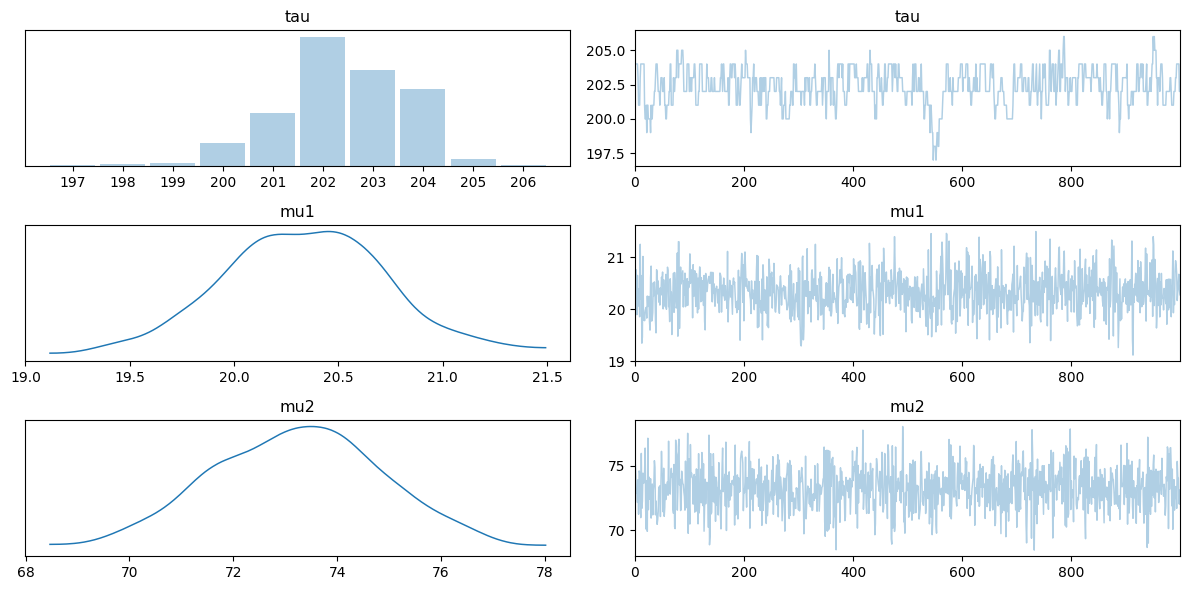

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,202.386,1.309,200.000,204.000,0.125,0.107,126.0,113.0,NaN
mu1,20.338,0.398,19.630,21.156,0.014,0.012,771.0,736.0,NaN
mu2,73.234,1.686,70.353,76.629,0.048,0.053,1211.0,611.0,NaN
sigma1,5.436,0.283,4.932,5.995,0.009,0.009,910.0,660.0,NaN
sigma2,25.615,1.186,23.457,27.764,0.036,0.035,1127.0,815.0,NaN


In [10]:
# Cell 4: Analyze posterior
import arviz as az
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2'])
plt.tight_layout()
plt.show()

az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])


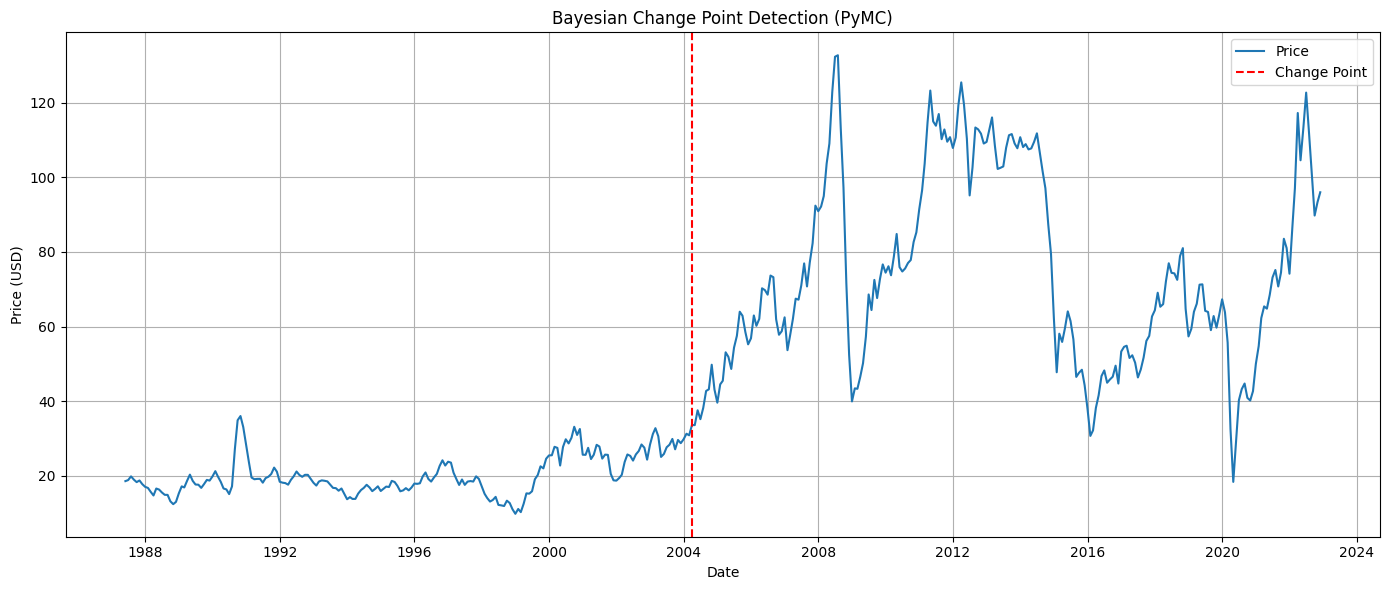

In [11]:
# Cell 5: Plot change point
tau_map = int(trace.posterior['tau'].mean().values)

plt.figure(figsize=(14, 6))
plt.plot(df_monthly['Date'], price, label='Price')
plt.axvline(df_monthly['Date'][tau_map], color='red', linestyle='--', label='Change Point')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bayesian Change Point Detection (PyMC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
